In [1]:
# %%
import matplotlib.pyplot as plt
from rdl_denoising.model_DFCAN import DFCAN
from rdl_denoising.loss_functions import mse_ssim
import tensorflow as tf
from csbdeep.io import load_training_data
from csbdeep.utils import plot_some
from pathlib import Path
import numpy as np
import cv2 
import os
from tensorflow.keras.models import load_model
import tifffile

from csbdeep.utils import normalize
import numpy.fft as F
import mrcfile
from pathlib import Path

import cv2 as cv
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
import math
from skimage.metrics import peak_signal_noise_ratio as psnr, mean_squared_error as mse, structural_similarity as ssim, normalized_root_mse as nrmse_sklearn
import io


2025-04-29 10:42:57.291791: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-29 10:42:57.457323: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-29 10:42:58.778269: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.conda/envs/thesis/lib/python3.10/site-packages/nvidia/cudnn/lib:/home/student/a/asarker/.conda/envs/thesis/lib/:/home/student/a/asarker/.co

In [21]:
# Set up paths
root_dir = '../dataset/microtubules/test'
# model_dir =  Path(root_dir)/'UNI_DATA_LOW_SNR_FIX_Final' # now trained for 02 as well
sr_model_dir =  "../trained_models/microtubules/DFCAN_complete"

output_dir = Path.cwd() / 'outputs' 
output_dir.mkdir(parents=True, exist_ok=True)
level = '04'
cell_numbers = ['001'] # put the list of image cells here

# iitialize and load the model

In [32]:
scale_gt = 2.0
init_lr = 1e-4
beta_1=0.9
beta_2=0.999

height, width, channels = 502,502,9
print(f'h: {height} , w: {width} , c: {channels}')
# height = int(height*scale_gt)
# width = int(width*scale_gt)
# print(f'h: {height} , w: {width} , c: {channels}')
# Load the model
if len(os.listdir(sr_model_dir)) > 0:
    
   
    sr_trained_model = DFCAN((height, width, channels), scale=2) # define the model with the sape of the image
    optimizer = Adam(learning_rate=init_lr, beta_1=beta_1, beta_2=beta_2)
    sr_trained_model.load_weights(sr_model_dir)
    sr_trained_model.compile(optimizer=optimizer, loss=mse_ssim)
    
else:
    raise ValueError(f'No model found in {sr_model_dir}')


h: 502 , w: 502 , c: 9


2025-04-29 11:20:04.679470: W tensorflow/core/util/tensor_slice_reader.cc:96] Could not open ../trained_models/microtubules/DFCAN_complete: DATA_LOSS: file is too short to be an sstable: perhaps your file is in a different file format and you need to use a different restore operator?


In [33]:
# for cell_number in cell_numbers:
## put it inside the for loop for performing prediction on multiple cells at a time


cell_number = '001'


mrc_file =  f'{root_dir}/Cell_{cell_number}/RawSIMData_level_{level}.mrc' #' 21, 30, 37'

gt_image =  f'{root_dir}/Cell_{cell_number}/SIM_gt.mrc'

with mrcfile.open(mrc_file, mode='r', permissive = True) as mrc:
    full_image = mrc.data

with mrcfile.open(gt_image, mode='r', permissive = True) as mrc:
    gt_full_image = mrc.data

print(full_image.shape)
print(gt_full_image.shape)

full_image = normalize(full_image)
gt_full_image = normalize(gt_full_image)


full_image = np.transpose(full_image, (2,1 , 0))
gt_full_image = np.transpose(gt_full_image, )


print(full_image.shape)
print(gt_full_image.shape)

# /share/klab/argha/RDL_denoising/examples/dataset/microtubules/train/Cell_010/RawSIMData_level_04.mrc



(9, 502, 502)
(1004, 1004)
(502, 502, 9)
(1004, 1004)


## lets look at the cells

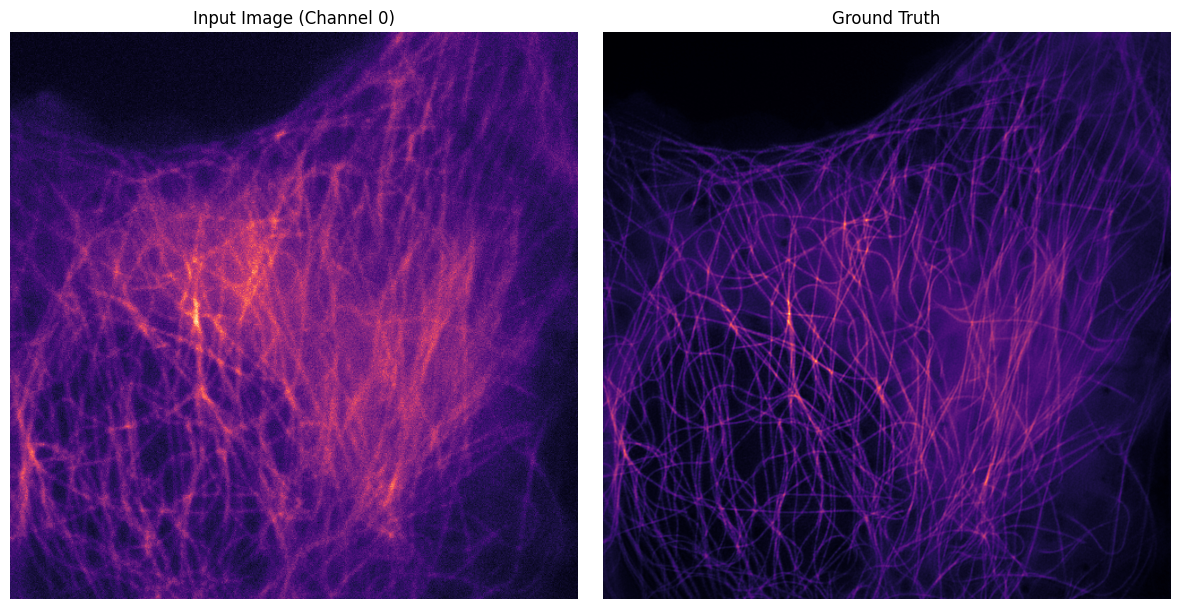

In [45]:
# Visualize the input image (one channel) and the ground truth side by side

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Assuming full_image has shape (9, 502, 502) after transpose,
# we choose the first channel (index 0) for display as a 502x502 image.
input_channel = full_image[...,1]
axes[0].imshow(input_channel.transpose(1,0), cmap='magma')
axes[0].set_title("Input Image (Channel 0)")
axes[0].axis('off')

# Ground truth image is assumed to be 1004x1004
axes[1].imshow(gt_full_image.transpose(1,0), cmap='magma')
axes[1].set_title("Ground Truth")
axes[1].axis('off')

plt.tight_layout()
plt.show()

# lets fo model preciction

In [37]:
_P_raw = sr_trained_model.predict(full_image[np.newaxis, ...])
_P_raw = normalize(np.squeeze(_P_raw))
print(_P_raw.shape)

1/1 [==============================] - 78s 78s/step
(1004, 1004)


# lets visualize the input, preiciton and GT together

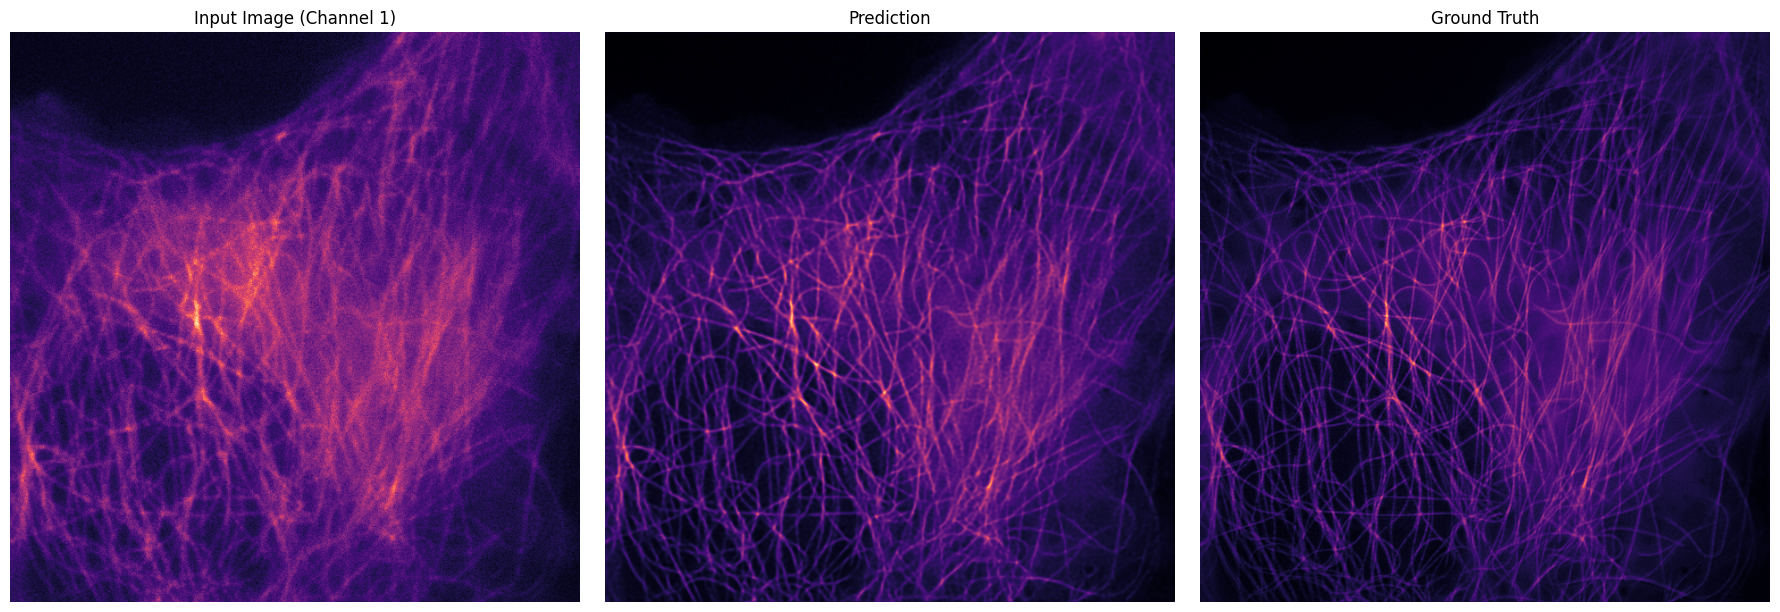

In [44]:
# Visualize the input image (one channel), prediction, and the ground truth side by side

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Input image (one channel from full_image)
input_channel = full_image[...,1].transpose(1,0)
axes[0].imshow(input_channel, cmap='magma')
axes[0].set_title("Input Image (Channel 1)")
axes[0].axis('off')

# Prediction image (assumed to be 1004x1004)
axes[1].imshow(_P_raw.transpose(1,0), cmap='magma')
axes[1].set_title("Prediction")
axes[1].axis('off')

# Ground truth image (assumed to be 1004x1004)
axes[2].imshow(gt_full_image.transpose(1,0), cmap='magma')
axes[2].set_title("Ground Truth")
axes[2].axis('off')

plt.tight_layout()
plt.show()